[View in Colaboratory](https://colab.research.google.com/github/corcra/datathon-obesity/blob/master/Obesity_Project.ipynb)

# Project Overview

# Cohort definition

## Inclusion

- Age >=18 and <= 89
- First ICU admission

## Exclusion

- Elective surgery

# Variables

## "Exposure variables"

- BMI (on admission)
  - Height 
  - Weight
- Age
- Gender

## Outcome

- 30 day mortality

## Covariates

- OASIS (possibly APACHE)
- Admission location
- Admitting diagnosis
  - Sepsis
  - Trauma
  - Major surgery
- CPR prior to admission
- Temperature on admission
- CRP on admission
  - D_ITEM :50889: C-Reactive Protein: Blood,Chemistry: 1988-5
  - D_ITEM: 227444: (in metavision)

# Environment setup

In [25]:
!pip install lifelines

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
from google.colab import files

# For statistics
import lifelines
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm



import pdb

In [0]:
auth.authenticate_user()

In [0]:
project_id='london-datathon'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

# Functions

In [0]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

In [0]:
def run_KM(df, survival_days, bins, varname):
  kmf = KaplanMeierFitter()
  fig, axarr = plt.subplots(nrows=1, ncols=1)
  for var in bins:
    duration = df.loc[df[varname + '_binned'] == var, 'mortality_days']
    event_observed = df.loc[df[varname + '_binned'] == var, 'mortality_days'] <= survival_days

    kmf.fit(duration, event_observed, label=str(var.left) + '-' + str(var.right))
    kmf.plot(xlim=(0, survival_days),  ylim=(0.5, 1), ax=axarr)
    plt.legend()

In [0]:
def get_survival_fractions(df, bins, varname='bmi'):
  survival_list = [df.loc[df[varname + '_binned'] == x, 'survival_days'].sum() for x in bins]
  nonsurvival_list = [(~df.loc[df[varname + '_binned'] == x, 'survival_days']).sum() for x in bins]
  fraction_list = [x[0]/(x[1] + x[0]) for x in zip(survival_list, nonsurvival_list)]
  return survival_list, nonsurvival_list, fraction_list

In [0]:
def compare_bmi_age_survival_fractions(df, bmi_bins, age_bins):
  survival_list_all, nonsurvival_list_all, fraction_list_all = get_survival_fractions(df, bmi_bins, varname='bmi')
  survival_list = [df.loc[df['bmi_binned'] == x, 'survival_days'].sum() for x in bmi_bins]
  nonsurvival_list = [(~df.loc[df['bmi_binned'] == x, 'survival_days']).sum() for x in bmi_bins]
  _ = plt.bar(x=np.arange(len(bmi_bins)), height=survival_list, tick_label=bmi_bins, label=str(survival_days) + ' day survival', width=0.3, align='edge')
  _ = plt.bar(x=np.arange(len(bmi_bins)) + 0.3, height=nonsurvival_list, tick_label=bmi_bins, label=str(survival_days) + ' day non survival', width=0.3, align='edge')
  _ = plt.xlabel('BMI bins')
  _ = plt.legend()


  fig, axarr = plt.subplots(nrows=2, ncols=2, sharey='row', figsize=(15, 10))

  ## First by BMI

  axarr[0, 0].bar(np.arange(len(bmi_bins)), height=fraction_list_all, tick_label=bmi_bins, color='grey')
  axarr[0, 0].set_xlabel("all patients; BMI bins")
  axarr[0, 0].set_ylim(0.5, 1.0)
  axarr[0, 0].set_ylabel("fraction of patients who survive" + str(survival_days) + " days")

  fraction_list_all = [x[0]/(x[1] + x[0]) for x in zip(survival_list_all, nonsurvival_list_all)]
  survival_list_all = [df.loc[df['bmi_binned'] == x, 'survival_days'].sum() for x in bmi_bins]
  nonsurvival_list_all = [(~df.loc[df['bmi_binned'] == x, 'survival_days']).sum() for x in bmi_bins]

  for i, sex in enumerate(['M', 'F']):
    survival_list, nonsurvival_list, fraction_list = get_survival_fractions(df.loc[df['gender'] == sex, :], bmi_bins, varname='bmi')
    axarr[0, 1].bar(np.arange(len(bmi_bins)) + i*0.3, height=fraction_list, tick_label=bmi_bins, width=0.3, label=sex, color=sex_colors[sex], align='edge')
    axarr[0, 1].legend()
    axarr[0, 1].set_xlabel("by sex; BMI bins")


  ## now by age
  _, _, fraction_list_age = get_survival_fractions(df, age_bins, varname='age')
  axarr[1, 0].bar(np.arange(len(age_bins)), height=fraction_list_age, tick_label=age_bins, color='grey')
  axarr[1, 0].set_xlabel("all patients; age bins")
  axarr[1, 0].set_ylim(0.5, 1.0)
  axarr[1, 0].set_ylabel("fraction of patients who survive " + str(survival_days) + " days")

  for i, sex in enumerate(['M', 'F']):
    survival_list, nonsurvival_list, fraction_list = get_survival_fractions(df.loc[df['gender'] == sex, :], age_bins, varname='age')
    axarr[1, 1].bar(np.arange(len(age_bins)) + i*0.3, height=fraction_list, tick_label=age_bins, width=0.3, label=sex, color=sex_colors[sex], align='edge')
    axarr[1, 1].legend()
    axarr[1, 1].set_xlabel("by sex; age bins")

In [0]:
def prepare_fit_data(df, catetgorical_variables, noncategorical_variables, survival_days):
  cat_inc = [x for x in categorical_variables if x in df.columns]
  noncat_inc = [x for x in noncategorical_variables if x in df.columns]
  df_fit = df.loc[:, noncat_inc].astype('float')
  for var in cat_inc:
    var_cat = pd.get_dummies(df[var], prefix=var)
    df_fit = pd.concat([df_fit, var_cat.iloc[:, :-1]], axis=1)
  df_fit['intercept'] = 1
  y = (df['mortality_days'] < survival_days).astype(int).values
  print(np.mean(y))
  if df_fit.isnull().sum().sum() > 0:
    print('dropping NA values')
    df_fit.dropna(axis=1, how='any', inplace=True)
  print(df_fit.shape, y.shape)
  return df_fit, y

def run_logistic_regression(X, y):
  logit = sm.Logit(y, X)
  try:
    result = logit.fit(disp=0)
  except:
    pdb.set_trace()
  return result

def get_OR(result):
  params = result.params
  conf = result.conf_int()
  conf['OR'] = params
  conf.columns = ['2.5%', '97.5%', 'OR']
  conf = np.exp(conf)
  return conf

In [0]:
def get_odds_ratios_for_different_groups(axarr, df, age_bins,
                                         covariate_list, cat_vars, noncat_vars, adjust=False,
                                        indep_var='bmi'):
  if adjust:
    covariates_included = covariate_list
  else:
    covariates_included = [indep_var]
  print(covariates_included)


  if adjust:
    axarr.set_xlabel('adjusted OR')
  else:
    axarr.set_xlabel('non-adjusted OR')
  axarr.set_yticklabels(['all'] + age_bins)
  axarr.set_yticks(np.arange(len(age_bins) + 1))
  
  for j, age_group in enumerate([None] + age_bins):
    if age_group is None:
      df_age = df.copy()
    else:
      df_age = df.loc[df['age_binned'] == age_group, :]
    axarr.axvline(1, linestyle='dashed')
    
    for k, sex in enumerate(['All', 'M', 'F']):
      if sex == 'All':
        df_subset = df_age.loc[:, covariates_included + ['mortality_days']]
      else:
        df_subset = df_age.loc[df_age['gender'] == sex, covariates_included + ['mortality_days']]
      X, y = prepare_fit_data(df_subset, cat_vars, noncat_vars, survival_days)
      n_patients = X.shape[0]
      result = run_logistic_regression(X, y)
      print(age, sex)
      print(result.summary())
      conf = get_OR(result)
      OR = conf['OR'][indep_var]
      lower = np.abs(OR - conf['2.5%'][indep_var])
      upper = np.abs(conf['97.5%'][indep_var] - OR)
      print(conf['2.5%'][indep_var], conf['OR'][indep_var], conf['97.5%'][indep_var])
      if j == 0:
        axarr.errorbar(x=OR, y=j + 0.2*(k%3), xerr=[[lower], [upper]], fmt='o', color=sex_colors[sex], label=sex)
      else:
        axarr.errorbar(x=OR, y=j + 0.2*(k%3), xerr=[[lower], [upper]], fmt='o', color=sex_colors[sex])
      axarr.text(x=OR + 1.02*upper, y=j + 0.2*(k%3), s=n_patients)
  axarr.legend()

# SQL for data extraction

In [0]:
query = """
with diagnosis_trauma as (
  select hadm_id,
     LOGICAL_OR(regexp_contains(icd9_code, "^8") or regexp_contains(icd9_code, "^9[0-5]")) as trauma
  from `physionet-data.mimiciii_clinical.diagnoses_icd`
  group by 1
),
services_reduced as (
  select hadm_id,
     array_agg(curr_service)[offset(0)] as curr_service
  from `physionet-data.mimiciii_clinical.services`
  group by 1
)
select
  isd.icustay_id, isd.subject_id, isd.gender, isd.admission_age as age,
  cast(hw.height_first as float64) as height,
  cast(hw.weight_first as float64) as weight,
  cast(hw.weight_first / ((hw.height_first/100)*(hw.height_first/100)) as float64) as bmi,
  datetime_diff(p.dod, isd.admittime, day) as mortality_days,
  datetime_diff(isd.dischtime, isd.admittime, day) as icu_days,
  datetime_diff(p.dod, isd.admittime, hour) as mortality_hours,
  datetime_diff(isd.dischtime, isd.admittime, hour) as icu_hours,
  apsiii.APSIII as apsiii,
  oasis.OASIS as oasis,
  sofa.SOFA as sofa,
  a.ADMISSION_LOCATION as admission_location,
  (sepsis.sepsis = 1 OR sepsis.septic_shock = 1 OR sepsis.severe_sepsis = 1) as sepsis,
  dt.trauma,
  case s.curr_service
    when "CSURG" then "SURG"
    when "DENT" then "SURG"
    when "ENT" then "SURG"
    when "GU" then "SURG"
    when "GYN" then "SURG"
    when "NSURG" then "SURG"
    when "ORTHO" then "SURG"
    when "PSURG" then "SURG"
    when "SURG" then "SURG"
    when "TRAUM" then "TRAUM"
    when "TSURG" then "SURG"
    when "VSURG" then "SURG"
    else NULL
  end as service,
  s.curr_service in ("CSURG","DENT","ENT","GU","GYN","NSURG","ORTHO","PSURG","SURG","TSURG","VSURG") as surgery,
  v.TempC_Max as temp,
  elix.CONGESTIVE_HEART_FAILURE as congestive_heart_failure,
  elix.CHRONIC_PULMONARY as chronic_pulmonary,
  elix.DIABETES_COMPLICATED as diabetes_complicated,
  elix.RENAL_FAILURE as renal_failure,
  elix.LIVER_DISEASE as liver_disease,
  elix.AIDS as aids,
  elix.LYMPHOMA as lymphoma,
  elix.METASTATIC_CANCER as metastatic_cancer,
  elix.SOLID_TUMOR as solid_tumor
from
  `physionet-data.mimiciii_clinical.icustay_detail` isd
inner join
  `physionet-data.mimiciii_clinical.heightweight` hw
  on isd.icustay_id = hw.icustay_id
inner join
  `physionet-data.mimiciii_clinical.admissions` a
  on isd.hadm_id = a.hadm_id
inner join
  `physionet-data.mimiciii_clinical.patients` p
  on isd.subject_id = p.subject_id
inner join
  `london-datathon.obesity.apsiii` apsiii
  on isd.icustay_id = apsiii.icustay_id
inner join
  `london-datathon.obesity.oasis` oasis
  on isd.icustay_id = oasis.icustay_id
inner join
  `london-datathon.obesity.sofa` sofa
  on isd.icustay_id = sofa.icustay_id 
inner join
  `london-datathon.obesity.sepsis` sepsis
  on isd.hadm_id = sepsis.hadm_id
inner join
  diagnosis_trauma dt
  on isd.hadm_id = dt.hadm_id
left join
  services_reduced s
  on isd.hadm_id = s.hadm_id
inner join
  `physionet-data.mimiciii_clinical.vitalsfirstday` v
  on isd.icustay_id = v.icustay_id
inner join
  `physionet-data.mimiciii_clinical.elixhauser_quan` elix
  on isd.hadm_id = elix.hadm_id
where
  hw.height_first is not null and hw.weight_first is not null           /* exclude unavailable height/weight*/
  and isd.admission_age >= 18 and isd.admission_age <= 89               /* exclude under 18 and over 89*/
  and (a.admission_type = "EMERGENCY" or a.admission_type = "URGENT")   /* exclude elective surgery */
  and hw.height_first > 90 and hw.height_first < 215                    /* exclude possibly incorrect heights */
  and isd.first_icu_stay                                                /* exclude readmission */
"""

# Cohort exploration



In [0]:
# constants etc
sex_colors = {'M':'#7fcdbb', 'F': '#2c7fb8', 'All': 'black'}
survival_colors = {True: '#7fbf7b', False: '#af8dc3'}

#bmi_cutoffs = np.array([18, 25, 30, 35, 100])
bmi_cutoffs = np.array([18, 25, 100])
age_cutoffs = np.array([18, 48, 68, 90])

# which types of variables are which type of what
categorical_all = ['admission_location']
noncategorical_all = ['apsiii', 'oasis', 'sofa', 'sepsis', 'trauma', 'surgical', 'bmi', 'congestive_heart_failure', 'chronic_pulmonary',
       'diabetes_complicated', 'renal_failure', 'liver_disease', 'aids',
       'lymphoma', 'metastatic_cancer', 'solid_tumor']
assert len(set(categorical_all).intersection(set(noncategorical_all))) == 0

In [0]:
df_orig = run_query('''select * from `london-datathon.obesity.cohort_data`''')

In [731]:
df = df_orig.copy()
print(df.shape)
survival_days = 90
min_days = 1
min_hours = min_days*24
df = df.loc[df['icu_hours'] > min_hours, :]
#df = df.loc[df['mortality_days'] > min_days, :]
df.loc[df['mortality_days'].isna(), 'mortality_days'] = survival_days + 2

df['survival_days'] = df['mortality_days'] > survival_days

df['bmi_binned'] = pd.cut(df['bmi'], bmi_cutoffs)
df['age_binned'] = pd.cut(df['age'], age_cutoffs)
bmi_bins = sorted(df['bmi_binned'].dropna().unique())
age_bins = sorted(df['age_binned'].dropna().unique())

(8915, 29)


In [732]:
print(df.columns)
n_patients = df.shape[0]
print('number of patients:', n_patients)

Index(['icustay_id', 'subject_id', 'gender', 'age', 'height', 'weight', 'bmi',
       'mortality_days', 'icu_days', 'mortality_hours', 'icu_hours', 'apsiii',
       'oasis', 'sofa', 'admission_location', 'sepsis', 'trauma', 'service',
       'surgery', 'temp', 'congestive_heart_failure', 'chronic_pulmonary',
       'diabetes_complicated', 'renal_failure', 'liver_disease', 'aids',
       'lymphoma', 'metastatic_cancer', 'solid_tumor', 'survival_days',
       'bmi_binned', 'age_binned'],
      dtype='object')
number of patients: 8709


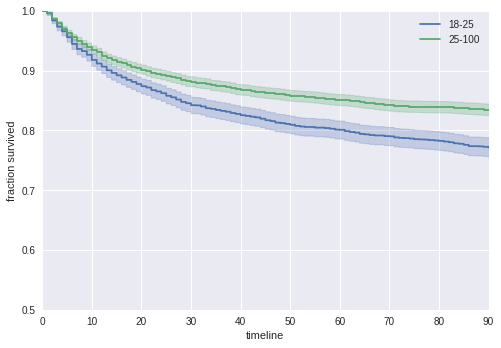

In [733]:
run_KM(df, survival_days, bmi_bins, 'bmi')
plt.ylabel('fraction survived')
plt.savefig("km_bmi.pdf")
#files.download("km_bmi.pdf")

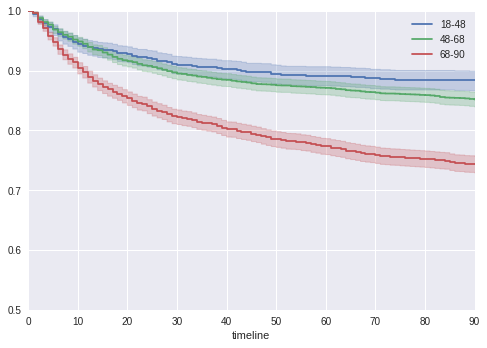

In [734]:
run_KM(df, survival_days, age_bins, 'age')

## BMI histograms


90-day survival: True
mean      28.764199
std        7.507370
median    27.486450
Name: bmi, dtype: float64
90-day survival: False
mean      27.571736
std        8.057150
median    26.100916
Name: bmi, dtype: float64


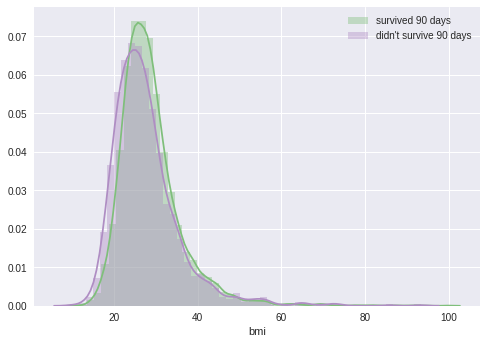

In [735]:
## Versus survival

for survival in [True, False]:
  print(str(survival_days) + '-day survival:', survival)
  _ = sns.distplot(df.loc[df['survival_days'] == survival, 'bmi'], kde=True, 
                   label='survived'*survival + 'didn\'t survive'*(1-survival) + ' ' +str(survival_days) + ' days', color=survival_colors[survival])
  print(df.loc[df['survival_days'] == survival, 'bmi'].agg(['mean', 'std', 'median']))
_ = plt.legend()
plt.savefig("surv_bmi_hist.pdf")
#files.download("surv_bmi_hist.pdf")

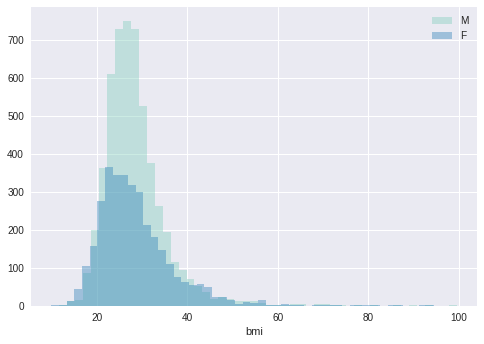

In [736]:
## Versus sex
for sex in ['M', 'F']:
  _ = sns.distplot(df.loc[df['gender'] == sex, 'bmi'], kde=False, label=sex, color=sex_colors[sex])
_ = plt.legend()
plt.savefig("bmi_sex.pdf")
#files.download("bmi_sex.pdf")

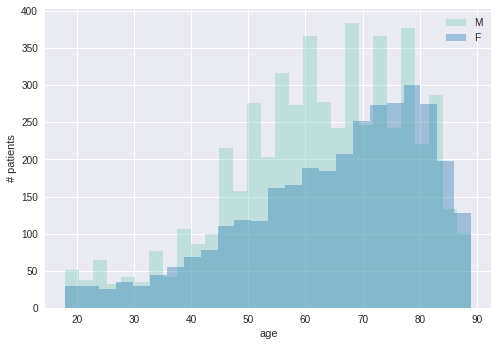

In [737]:
## Versus sex
for sex in ['M', 'F']:
  _ = sns.distplot(df.loc[df['gender'] == sex, 'age'], kde=False, label=sex, color=sex_colors[sex])
_ = plt.legend()
plt.ylabel('# patients')
plt.savefig("age.pdf")
#files.download("age.pdf") 

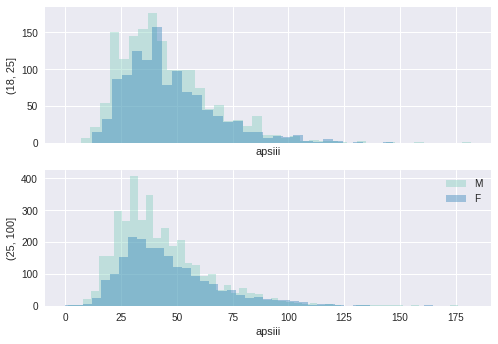

In [738]:
## Versus sex
fig, axarr = plt.subplots(nrows=len(bmi_bins), sharex='col')
for i, bmi in enumerate(bmi_bins):
  df_bmi = df.loc[df['bmi_binned'] == bmi, :]
  for sex in ['M', 'F']:
    _ = sns.distplot(df_bmi.loc[df_bmi['gender'] == sex, 'apsiii'], kde=False, label=sex, color=sex_colors[sex], ax=axarr[i])
  axarr[i].set_ylabel(bmi)
_ = plt.legend()
plt.savefig("apsiii_bmi.pdf")
#files.download("apsiii_bmi.pdf")

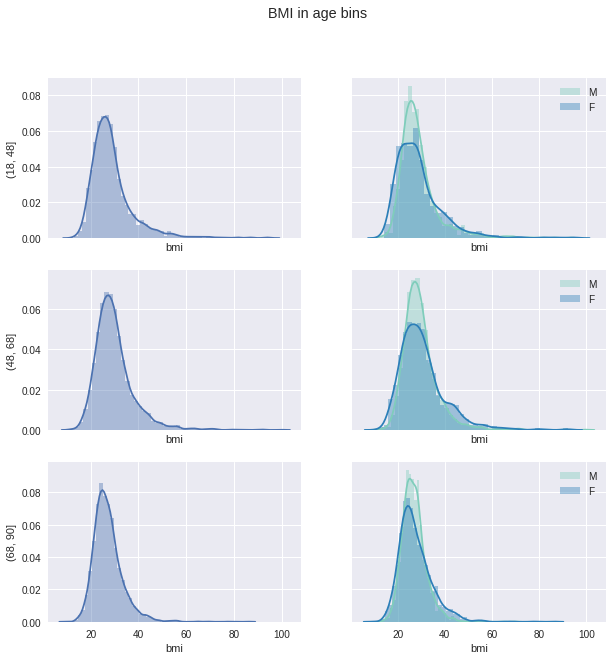

In [739]:
## Versus age
fig, axarr = plt.subplots(nrows=len(age_bins), ncols=2, sharex='col', sharey='row', figsize=(10, 10))
for i, age in enumerate(age_bins):
  #print(df.loc[df['age_binned'] == age, :].shape[0])
  _ = sns.distplot(df.loc[df['age_binned'] == age, 'bmi'], kde=True, ax=axarr[i, 0])
  axarr[i, 0].set_ylabel(age)
  for sex in ['M', 'F']:
    _ = sns.distplot(df.loc[(df['age_binned'] == age)&(df['gender'] == sex), 'bmi'], kde=True, color=sex_colors[sex], ax=axarr[i, 1], label=sex)
  axarr[i, 1].legend()
_ = axarr[-1, 0].set_xlabel('bmi')
_ = axarr[-1, 1].set_xlabel('bmi')
_ = plt.suptitle('BMI in age bins')

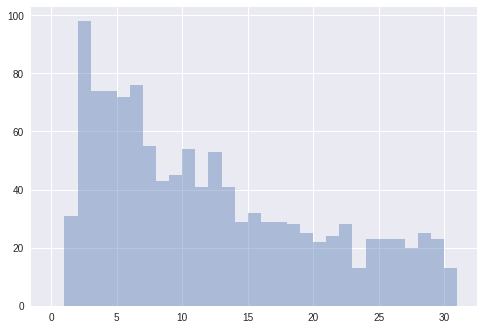

In [740]:
# Distribution of survival times
survival_times = df['mortality_days'].dropna().values.astype(float)
max_time = 30
survival_times = survival_times[survival_times <= max_time]
_ = sns.distplot(survival_times, kde=False, bins=np.arange(0, 32, 1))

## X-day survival proportions

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


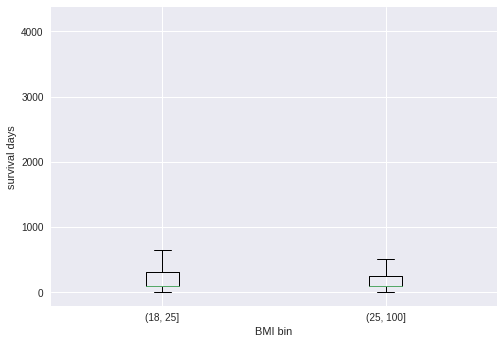

In [741]:
## WARNING: this analysis is misleading
df_withmortality = df.loc[df['mortality_days'].notna(), :]
bin_list = [df_withmortality.loc[df_withmortality['bmi_binned'] == x, 'mortality_days'] for x in bmi_bins]
_ = plt.boxplot(bin_list, labels=bmi_bins)
_ = plt.ylabel("survival days")
_ = plt.xlabel("BMI bin")

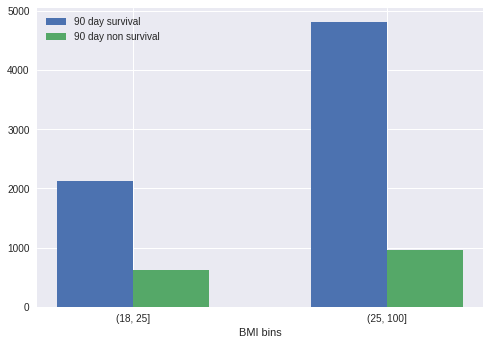

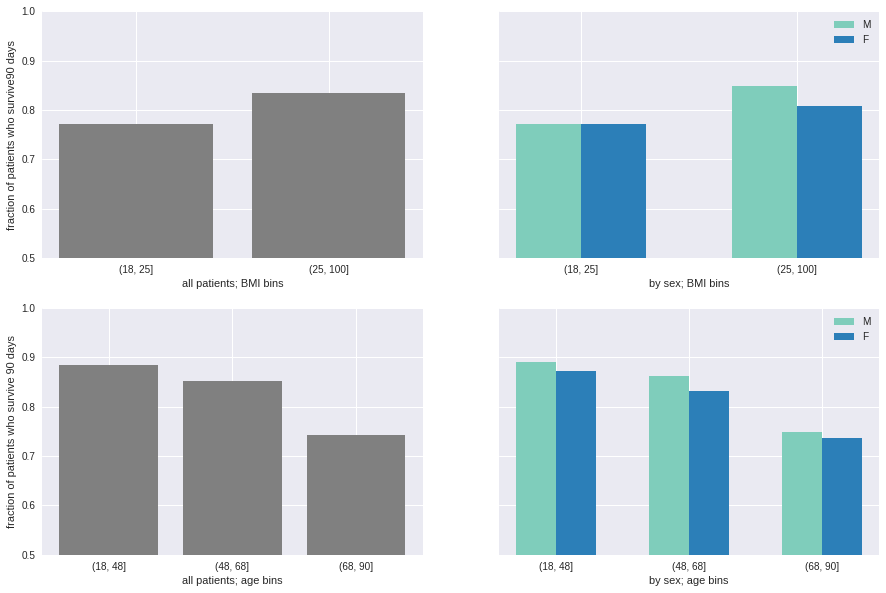

In [742]:
compare_bmi_age_survival_fractions(df, bmi_bins, age_bins)
plt.savefig("bmi_surv.pdf")
#files.download("bmi_surv.pdf")

## List of plots:

- Histogram for age & BMI, for men and women separately (overlay)
- Bar plot 30-day survival proportion for BMI bins for men & women separately, also for age bins
  - Cutoffs: 18-25, 25-30, 30-35, 35-100
- Temp or CRP v. BMI, men and women (scatter plot)
  - Multiple plots: bin ages
  - Cutoffs: 18-48, 48-68, 68-89
- Adjusted odds ratio for 90-day mortality for different BMI ranges
  - separately for gender
  - separately for age

# Multiple logistic regression

In [0]:
covariate_list = ['admission_location', 'apsiii', 'sepsis', 'trauma', 'surgical', 'bmi', 'congestive_heart_failure', 'chronic_pulmonary',
       'diabetes_complicated', 'renal_failure', 'liver_disease', 'aids',
       'lymphoma', 'metastatic_cancer', 'solid_tumor']
noncategorical_variables = [x for x in covariate_list if x in noncategorical_all]
categorical_variables = [x for x in covariate_list if x in categorical_all]

['admission_location', 'apsiii', 'sepsis', 'trauma', 'surgical', 'bmi', 'congestive_heart_failure', 'chronic_pulmonary', 'diabetes_complicated', 'renal_failure', 'liver_disease', 'aids', 'lymphoma', 'metastatic_cancer', 'solid_tumor']
['admission_location', 'apsiii', 'sepsis', 'trauma', 'surgical', 'bmi', 'congestive_heart_failure', 'chronic_pulmonary', 'diabetes_complicated', 'renal_failure', 'liver_disease', 'aids', 'lymphoma', 'metastatic_cancer', 'solid_tumor']
0.18922953266735562
dropping NA values
(8709, 12) (8709,)
(68, 90] All
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 8709
Model:                          Logit   Df Residuals:                     8697
Method:                           MLE   Df Model:                           11
Date:                Sun, 09 Sep 2018   Pseudo R-squ.:                  0.1471
Time:                        13:43:32   Log-Likelihood:         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encou

0.17640470412544335
dropping NA values
(5357, 12) (5357,)
(68, 90] M
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5357
Model:                          Logit   Df Residuals:                     5345
Method:                           MLE   Df Model:                           11
Date:                Sun, 09 Sep 2018   Pseudo R-squ.:                  0.1722
Time:                        13:43:32   Log-Likelihood:                -2066.0
converged:                      False   LL-Null:                       -2495.8
                                        LLR p-value:                2.806e-177
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
apsiii                                           0.0421      0.002     21

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.11637347767253045
dropping NA values
(1478, 12) (1478,)
(68, 90] All
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1478
Model:                          Logit   Df Residuals:                     1466
Method:                           MLE   Df Model:                           11
Date:                Sun, 09 Sep 2018   Pseudo R-squ.:                  0.1992
Time:                        13:43:32   Log-Likelihood:                -425.64
converged:                      False   LL-Null:                       -531.54
                                        LLR p-value:                 2.626e-39
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
apsiii                                           0.0405      0.004     

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(68, 90] All
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3413
Model:                          Logit   Df Residuals:                     3402
Method:                           MLE   Df Model:                           10
Date:                Sun, 09 Sep 2018   Pseudo R-squ.:                  0.1698
Time:                        13:43:32   Log-Likelihood:                -1184.8
converged:                       True   LL-Null:                       -1427.1
                                        LLR p-value:                 8.517e-98
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
apsiii                                           0.0385      0.002     15.695      0.000       0.034       0.043
sepsis          

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(68, 90] All
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3801
Model:                          Logit   Df Residuals:                     3789
Method:                           MLE   Df Model:                           11
Date:                Sun, 09 Sep 2018   Pseudo R-squ.:                  0.1255
Time:                        13:43:33   Log-Likelihood:                -1890.8
converged:                      False   LL-Null:                       -2162.1
                                        LLR p-value:                2.689e-109
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
apsiii                                           0.0357      0.002     16.490      0.000       0.031       0.040
sepsis          

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


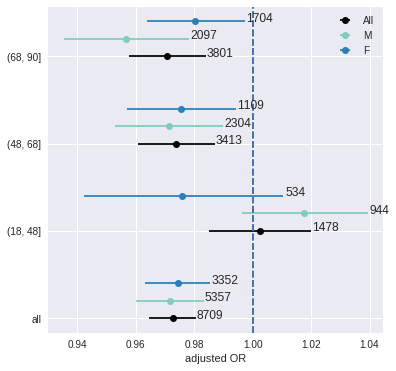

In [747]:
print(covariate_list)
fig, axarr = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(6, 6))
  
get_odds_ratios_for_different_groups(axarr, df, age_bins, 
                                         covariate_list, categorical_variables, noncategorical_variables, adjust=True)
#get_odds_ratios_for_different_groups(axarr[1], df, age_bins, 
#                                         covariate_list, categorical_variables, noncategorical_variables, adjust=False)



plt.savefig("AOR.pdf")
files.download("AOR.pdf") 